In [28]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  4 15:49:44 2021

@author: menglu
"""
#!pip install mgwr

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import xgboost as xgb
#from sklearn.model_selection import train_test_split
#from sklearn import metrics
import os
#from scipy import stats
from pandas import read_csv  
from sklearn.impute import SimpleImputer 
#from merf import MERF
#import math
#import inspect
#from sklearn.ensemble import RandomForestRegressor

#from catboost import CatBoostRegressor, Pool
#import lightgbm as lgb
#import seaborn as sns
import matplotlib.pyplot as plt
#import rasterio
#import rasterio.mask 
import geopandas as gpd
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR
 

/opt/anaconda3/envs/sa/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/envs/sa/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


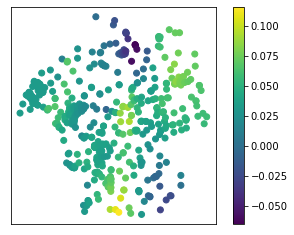

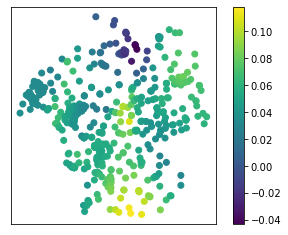

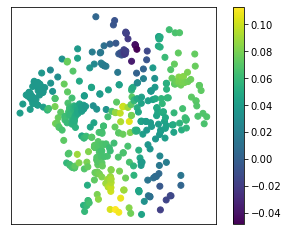

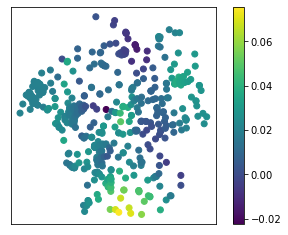

Model type                                                         Gaussian
Number of observations:                                                 484
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          22065.573
Log-likelihood:                                                   -1611.131
AIC:                                                               3252.262
AICc:                                                              3255.427
BIC:                                                              19166.175
R2:                                                                   0.689
Adj. R2:                                                              0.680

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [38]:

#os.getcwd()

# if we just do random sampling in space-time. We have a quite high R2. 
# But it is because if the Location 1 t1 is in the training, then the L1 t2 is going to be small. So it is not a reliable accuracy assessment. 
# Most importantly, for the location we want to predict, we dont know the entire time series.

spreadurl = 'https://raw.githubusercontent.com/mengluchu/mobiair/master/mapping_data/DENL17_hr_spread.csv'
res = 100 
ap = pd.read_csv(spreadurl)

#check NA
ap['MeasurementEquipment'].isnull().sum() # consists the most NA, some other variabels only 1 NA
#is_NaN.any(axis=1)
#is_NaN.any(axis=0)
#ap["Unnamed: 0"][is_NaN.any(axis=1)]
#is_NaN.any(axis=0).index[is_NaN.any(axis=0)]
 

if res == 100:
    ap = ap.drop(ap.filter(regex='_25$|_50$').columns, axis = 1)
ap_gdf = gpd.GeoDataFrame(ap,crs={'init': 'epsg:4326'},
                                     geometry=gpd.points_from_xy(ap.Longitude, ap.Latitude))
results= gpd.GeoDataFrame(crs={'init': 'epsg:4326'},
                                     geometry=gpd.points_from_xy(ap.Longitude, ap.Latitude))
 
hrs = [7,12,17,22]
#hrs = range(24)
#ap_pred = ap_gdf.filter (regex="pop|nig|trop|road_class_2|road_class_3|7|12|17|22")
# used in the INLA model, most important variables
'''
ap_pred = ap_gdf[["nightlight_450", "population_1000", "population_3000",
              "road_class_1_5000", "road_class_2_100", "road_class_3_300", "trop_mean_filt",
              "road_class_3_3000", 
              "road_class_1_100", "road_class_3_100",
              "road_class_3_5000", "road_class_1_300", "road_class_1_500",
              "road_class_2_1000", "nightlight_3150", "road_class_2_300", "road_class_3_1000", 
             "temperature_2m_7"]]
'''

# remove most primary road variables, they are not in RF as well 
ap_pred = ap_gdf[["nightlight_450", "population_1000", "population_3000",
              "road_class_1_5000", "road_class_2_100", "road_class_3_300",  
              "road_class_3_3000","road_class_3_100",
              "road_class_3_5000", 
              "road_class_2_1000", "nightlight_3150", "road_class_2_300", "road_class_3_1000", 
             "temperature_2m_7"
              ]]
# including road class1 100 m cause the problem of singular matrix, maybe due to too many zeros. 
ap_resp = ap_gdf[[*[str(hrs[i]) for i in range(len(hrs))]]]
my_imputer = SimpleImputer(missing_values=np.nan, strategy='constant')
ap_resp = my_imputer .fit_transform(ap_resp)  
ap_resp.shape
#             str(hrs[0]),str(hrs[1]),str(hrs[2]),str(hrs[3])]]
filedir = "~/Documents/GitHub/gwr_hr/"
resultdir = "~/Documents/GitHub/gwr_hr/result/"

 
bw0= []
r2 = []
for i in range(len(hrs)):
    
    #y = ap_resp [str(hrs[i])].values.reshape((-1, 1))
    gX = ap_pred.values 
    
    gy = ap_resp[:,i].reshape(-1,1)
    #X = my_imputer .fit_transform(X)  
    #y = my_imputer .fit_transform(y)  
   # print(gX.shape, gy.shape) 
    gcoords = list(zip(ap['Longitude'], ap['Latitude'] ))
    
    bw = Sel_BW(gcoords, gy,gX,kernel='gaussian').search(criterion='CV')# search bandwith, default bisquared
    bw # band width less variables - > smaller bandwith
    bw0.append(bw)
    gwr_results = GWR(gcoords, gy, gX,bw).fit() 
    r2.append(gwr_results.R2)
    results['R2'] = gwr_results.localR2     #results is a geodataframe that is defined earlier
    results["coef0"] = gwr_results.params[:,5] #road 2 in 100, buffer
 
    #results.plot('R2', legend = True) 
   # ax = plt.gca() 
    #ax.get_xaxis().set_visible(False) 
    #ax.get_yaxis().set_visible(False) 
   # plt.savefig(f'{resultdir}R2_hr{str(hrs[i])}') 
    #plt.show()
    
    results.plot('coef0', legend = True) 
    ax = plt.gca() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
   # plt.savefig(f'{resultdir}R2_hr{str(hrs[i])}') 
    plt.show()
plt.close('all')

gwr_results.summary()
print("bandwidth at hour 7,12, 17, 22",bw0)


#ax.get_xaxis().set_visible(False) 
#ax.get_yaxis().set_visible(False) 
#plt.savefig('local_R2_bandwidth=264') 
#plt.show()


selector = Sel_BW(gcoords, gy, gX, multi=True, constant=True)
 
#bw = selector.search(multi_bw_min=[277], multi_bw_max=[280])

#mgwr = MGWR(gcoords, y, X, selector, constant=True)

#mgwr_results = mgwr.fit()
#print('aicc:', mgwr_results.aicc)
#print('sigma2:', mgwr_results.sigma2)
#print('ENP(model):', mgwr_results.ENP)
#print('adj_alpha(model):', mgwr_results.adj_alpha[1])
#print('critical_t(model):', mgwr_results.critical_tval(alpha=mgwr_results.adj_alpha[1]))
# same resutls with normalisation. 
#X = (X - X.mean(axis=0)) / X.std(axis=0)
#y = (y - y.mean(axis=0)) / y.std(axis=0)
#sel = Sel_BW(g_coords, g_y, g_X)
#bw = sel.search()
#bw
